<a href="https://colab.research.google.com/github/nagae/ICL_B_2021/blob/main/case_death_rate_weekly_growth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 感染死亡率(14日ラグ)とその週間成長率を求める

感染死亡率として，以下を定義する：
以下，[平均感染期間が5日程度](https://www.niid.go.jp/niid/ja/typhi-m/iasr-reference/2536-related-articles/related-articles-492/10177-492r02.html)という情報があったので感染から死亡までのラグを**1週間**としてみます．つまり，
```
t日目の感染死亡率 = t日目の累積死亡数 ÷ (t-7)日目の累積感染数
```
とします．ただし，$t<7$の場合は感染死亡率は未定義(`NaN`)とします．

データフレーム`global_df` の各国についてこれを計算したものを `case_death_rate` という列に加えるには，下記のようにします：
```
total_deaths = global_df.groupby("location")["total_deaths"].shift() # 各国の累積死亡数
total_cases7 = global_df.groupby("location")["total_cases"].shift(7) # 各国の7日前累積死亡数
global_df["case_death_rate"] = total_deaths/total_cases7 # 7日前感染数に対する死亡数
```

In [1]:
# 必要なモジュールのインポート
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, dates as mdates
import datetime
# CSVをデータフレームに読み込む（ちょっと重い）
global_df = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv')
# 年-月-日の文字列で記載されている年月日を datetime 型に変更
global_df["date"]=pd.to_datetime(global_df["date"], format="%Y-%m-%d")
# 県別でも扱ったマルチインデックスとして整形
global_df = global_df.set_index(["location", "date"])
global_df # global_df の概観を表示

iso_code  ... human_development_index
location    date                 ...                        
Afghanistan 2020-02-24      AFG  ...                   0.511
            2020-02-25      AFG  ...                   0.511
            2020-02-26      AFG  ...                   0.511
            2020-02-27      AFG  ...                   0.511
            2020-02-28      AFG  ...                   0.511
...                         ...  ...                     ...
Zimbabwe    2021-05-19      ZWE  ...                   0.571
            2021-05-20      ZWE  ...                   0.571
            2021-05-21      ZWE  ...                   0.571
            2021-05-22      ZWE  ...                   0.571
            2021-05-23      ZWE  ...                   0.571

[90732 rows x 57 columns]

In [11]:
# 感染から死亡までに14日間のラグがあるとして求めた感染死亡率をデータフレームに追加する
total_deaths = global_df.groupby("location")["total_deaths"].shift()
total_cases7 = global_df.groupby("location")["total_cases"].shift(7)
global_df["case_death_rate"] = total_deaths/total_cases7

# 国名でない地域名
area_list = ['World', 'Asia', 'Europe', 'North America', 'European Union', 'South America', 'Africa']

# 地域名
# 感染死亡率の週間成長率を求める
case_death_rate = global_df.groupby("location")["case_death_rate"]
global_df["case_death_rate_weekly_growth"] = case_death_rate.diff(7)/case_death_rate.shift(7)

rank = 30 # 上位何位までを表示するか
CDR_WG = global_df.groupby("location")["case_death_rate_weekly_growth"].last() # 直近の感染死亡率の週間成長率
CDR_WG = CDR_WG.drop(index=area_list) # インデックスが国名ではなく地域となっている行を取り除く
CDR_WG = CDR_WG.sort_values(ascending=False).head(rank) # 残った要素を降順に並べ替え，rank 個の上位要素を取り出す

CDR_WG # 感染死亡率の直近週間成長率が大きい国

location
Antigua and Barbuda      0.262472
Eritrea                  0.135709
Mongolia                 0.107533
Malaysia                 0.104675
Sri Lanka                0.104176
Thailand                 0.104053
Nepal                    0.099028
Trinidad and Tobago      0.086527
Cameroon                 0.075521
Jamaica                  0.067881
Namibia                  0.058012
Maldives                 0.052586
Guinea                   0.041159
Paraguay                 0.038178
Sudan                    0.036998
Bahrain                  0.034222
Singapore                0.028470
Sao Tome and Principe    0.024593
Angola                   0.024013
Uruguay                  0.022756
Madagascar               0.022143
Qatar                    0.021710
Oman                     0.021260
Venezuela                0.019758
Lesotho                  0.017145
Turkey                   0.017050
Suriname                 0.017050
Tunisia                  0.015975
Barbados                 0.015300
North

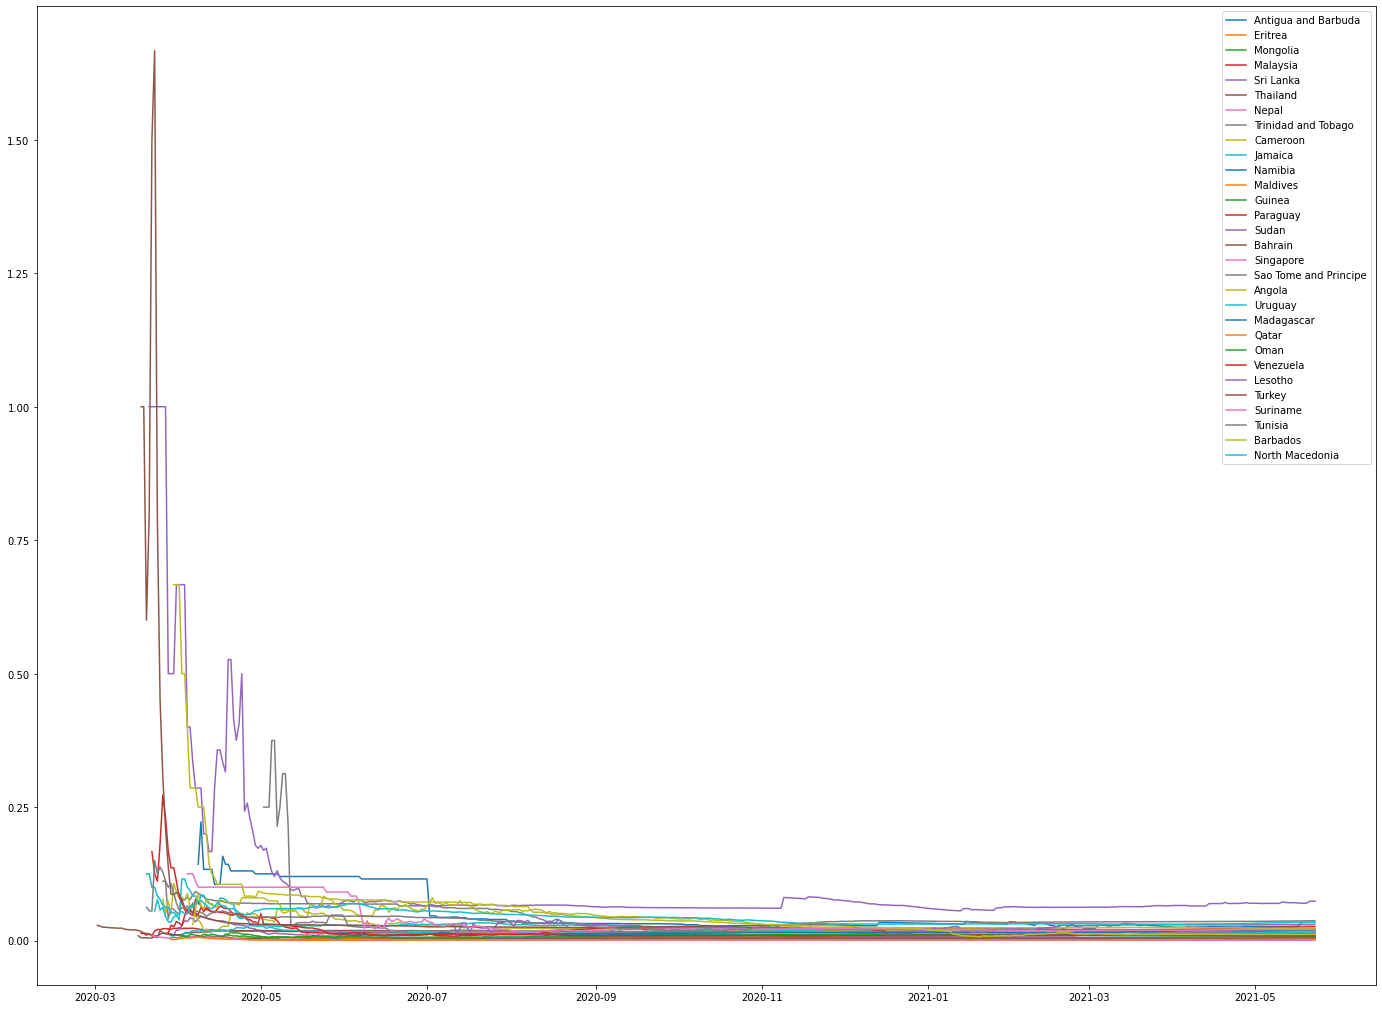

In [13]:
# 折れ線グラフでプロット
fig = plt.figure(figsize=(24,18)) # 大きめのキャンバスを準備
for country in CDR_WG.index:
    plt.plot(global_df.loc[country]["case_death_rate"], label=country)
plt.legend()
plt.show()